## 线性回归

仿射变换（affine transformation）。仿射变换的特点是通过加权和对特征进行线性变换（linear transformation），并通过偏置项来进行平移（translation）。



## 损失函数

损失函数（loss function）能够量化目标的实际值与预测值之间的差距。

线性回归的解可以用一个公式简单地表达出来，这类解叫作解析解（analytical solution）。

## 随机梯度下降

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本，这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

在每次迭代中，我们首先随机抽样一个小批量B，它是由固定数量的训练样本组成的。然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。最后，我们将梯度乘以一个预先确定的正数η，并从当前参数的值中减掉。

## 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。为了实现这一点，需要我们对计算进行矢量化，从而利用线性代数库，而不是在Python中编写开销高昂的for循环

In [39]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import random
from d2l import torch as d2l

In [40]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [41]:
#定义计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [42]:
#测试for循环的速度
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.06050 sec'

In [43]:
#用torch重载的+来运算快得多
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 正态分布与平方损失

正态分布和线性回归之间的关系很密切，数据点应该是符合正态分布的，因此通过最大似然可以估计参数

在高斯噪声的假设下，最小化均方误差（损失函数）等价于对线性模型的极大似然估计。

##  线性回归的从零开始实现

在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$


In [44]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    #矩阵相乘，w可以视为nx1大小的矩阵
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [45]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
#注意，features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）。
print('features:', features[0],'\nlabel:', labels[0])
print(features.shape)
print(labels.shape)

features: tensor([-0.9662,  2.1861]) 
label: tensor([-5.1775])
torch.Size([1000, 2])
torch.Size([1000, 1])


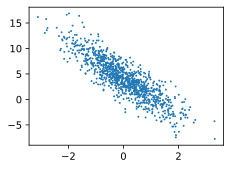

In [46]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。


在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [47]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        #batch_indices是tensor类型的一堆索引
        #print('batch_indices',batch_indices)
        yield features[batch_indices], labels[batch_indices]

In [48]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.7127, -0.6122],
        [-0.9299,  1.0085],
        [ 0.5520, -0.7410],
        [ 0.4666,  0.7033],
        [ 0.8979, -0.0759],
        [-0.6589, -0.6296],
        [-0.4675, -0.4035],
        [ 0.2627,  1.2721],
        [ 1.5961,  0.5374],
        [-0.9028, -0.1467]]) 
 tensor([[ 9.7113],
        [-1.0664],
        [ 7.8163],
        [ 2.7322],
        [ 6.2607],
        [ 5.0361],
        [ 4.6342],
        [ 0.3856],
        [ 5.5650],
        [ 2.8923]])


上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。例如，它要求我们将所有数据加载到内存中，并
执行大量的随机内存访问。在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和数据流提供的数据

## 初始化模型参数


In [49]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print('initial w:',w)
print('initial b:',b)

initial w: tensor([[-0.0067],
        [ 0.0180]], requires_grad=True)
initial b: tensor([0.], requires_grad=True)


In [50]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [51]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [52]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            #除以batch_size是应为梯度是batch_size个样本的梯度之和
            #这里用的-=，在python中会执行原地操作（in-place operation），也就导致了全局param的改变
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

In [53]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [54]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041852
epoch 2, loss 0.000164
epoch 3, loss 0.000051


In [37]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0010], grad_fn=<RsubBackward1>)
